# Sommaire
le but de l'exercice est faire sur la Loire-Atlantique: 
- La collecte des données pour chaque commune nom, prenom, adresse des praticiens (ameli.fr & data.gouv.fr)
- L'aggregation
- L'analyse des résultats, présentation

De ce fait je vais grace à l'importation des librairies, récupérer les données des praticiens, ensuite récupérer les habitans de chaque commune et en fin faire l'analyse et l'interprétation des résultats


# Import libraries
les librairies dont nous aurons besoin:
- pandas
- beautiful soup
- request
- re
- numpy
- matplotlib

- importation des librairies

In [93]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

## Partie 1: récupération des praticiens

- l'url donnant accés à tous les praticiens des communes de la loire atlantique

In [94]:
dep = 44
url = f"http://annuairesante.ameli.fr/trouver-un-professionnel-de-sante/chirurgiens-dentistes/{dep}-loire-atlantique"
base_url = "http://annuairesante.ameli.fr"

- récupération des données à partir de la page de l'url ensuite parser en html

In [95]:
response = requests.get(url)
soup = BeautifulSoup(response.text,'html.parser')
a_href = soup.findAll('a')

- la liste des url des commune de la loire:
    list_url_ville  
- liste des noms des communes et leurs code postaux:
    list_ville
- on ignore les 3 premiers et les 6 derniers éléments de la liste des résultats dans a_href:
    a_href = a_href[3:-6]

In [96]:
list_url_ville = [] 
list_ville = [] 
a_href = a_href[3:-6]
for link in a_href:
    if link.has_attr('href'):
        list_url_ville.append(link['href'])
        list_ville.append(link.text)

fonction permettant de récupérer les informations des praticiens dont les entrées sont le nom de la commune et url de la commune contenant les informations des praticiens

In [97]:
def get_praticien_ville(ville, url):
    response_name = requests.get(base_url + url)
    soup_name = BeautifulSoup(response_name.text, 'html.parser')
    name = soup_name.findAll('a')
    adress = soup_name.findAll(class_="item left adresse")
    
    # contient le nom et le prenom de tous les praticiens de la ville
    name_clean = [] 
    for n in name:
        if n.strong:
            name_clean.append(n)
            
    # liste des informations des praticiens de la ville: nom, adresse et ville
    list_info_praticiens = [] 
    for j in range(len(name_clean)):
        
        info_praticiens = {}        
        info_praticiens['nom'] = name_clean[j].text
        info_praticiens['adress'] = adress[j].text
        info_praticiens['ville'] = ville
        list_info_praticiens.append(info_praticiens)
        
    return list_info_praticiens


liste contenant les informations de tous les praticiens de toutes les communes de la loire atlantique

In [113]:
all_praticiens = [] 
for i in range(len(list_url_ville)):
    praticiens = get_praticien_ville(list_ville[i], list_url_ville[i])
    all_praticiens.extend(praticiens)     
# all_praticiens

on crée un dataframe à partir de la liste des informations de tous les praticiens du département de la loire

In [100]:
df = pd.DataFrame(all_praticiens)

Nous avons dans notre table un total de 667 praticiens sur tout le département de la loire Atlantique.

In [101]:
df.shape

(667, 3)

Ajoutons une colonne code postal avec une expression régulière en le récupérant à partir de la colonne ville

In [102]:
df['code_postal'] = df.ville.apply(lambda x: re.findall('\d+', x)[0])

ajout effctué, code_postal présent

In [103]:
df.dtypes

nom            object
adress         object
ville          object
code_postal    object
dtype: object

j'agrège (groupby) les données par code postal pour avoir le nombre de praticien par code postal

In [104]:
groupby_code_postal = df.groupby(['code_postal']).size().reset_index()
groupby_code_postal.columns=['code_postal','nb_praticiens']
groupby_code_postal

,code_postal,nb_praticiens
0,44000,19
1,44110,15
2,44115,19
3,44116,2
4,44117,6
...,...,...
66,44840,4
67,44850,7
68,44860,9
69,44880,8


ci_dessus on onstate que l'agregation est faite, nous avons au total 71 codes postaux et le nombre de praticien pour chacun des codes postaux

## Partie 2: récupération de la population
 Après avoir récupérer les données sur les particiens, nous allons récupérer la population totale pour chaque commune

Récupération deux fichiers csv dont l'un contient la population mais au niveau commune et donc j'ai besoin de l'autre fichier pour faire le lien entre commune et code postal

- lecture du fichier csv contenant les données de recensement des codes communes et départementaux, des noms des communes en france

In [105]:
code_commune = pd.read_csv("donnees_communes.csv", sep=";")

- lecture du  fichier csv contenant les noms des communes, les dode postaux, les codes communes

In [106]:
code_commune_post = pd.read_csv("laposte_hexasmal.csv", sep=";")

- rajout d'une colonne code_commune_insee en faisant la concaténation du code département et du code commune qui nous permettra de faire la liaison des deux fichiers.

In [107]:
code_commune.CODCOM=code_commune.CODCOM.apply(lambda x : str(x).zfill(3))
code_commune['code_commune_insee']=code_commune.CODDEP+code_commune.CODCOM

merge des deux fichiers afin d'avoir la liaison entre les codes postaux et les nombres d'habitants grâce à leur colonne commune qui est code_commune_insee

In [108]:
merges=pd.merge(code_commune_post,code_commune,on='code_commune_insee')
merges.code_postal=merges.code_postal.astype(str)

je récupère les colonnes code postal et population totale (pour toutes les communes de France)

In [109]:
merges=merges[["code_postal","PTOT"]]
merges

,code_postal,PTOT
0,25650,343
1,25640,151
2,26150,436
3,26150,436
4,26770,50
...,...,...
38712,95760,1238
38713,95270,5267
38714,95570,783
38715,95380,1520


Après avoir récupérer le code postal et la population totale,
je fais le merge avec le dataFrame #groupby_code_postal afin d'avoir code postal,
nombre de praticien et la population totale par code postal et le nombre d'habitant/nb_praticien pour le département de la loire atlantique


In [110]:
newDataFrame=groupby_code_postal.merge(merges,on ="code_postal",how='inner')
newDataFrame['population_sur_nb_praticiens']=newDataFrame.PTOT/newDataFrame.nb_praticiens
newDataFrame

,code_postal,nb_praticiens,PTOT,population_sur_nb_praticiens
0,44000,19,323975,17051.315789
1,44110,15,696,46.400000
2,44110,15,12528,835.200000
3,44110,15,1815,121.000000
4,44110,15,2059,137.266667
...,...,...,...,...
227,44860,9,6557,728.555556
228,44860,9,6557,728.555556
229,44860,9,4014,446.000000
230,44880,8,8644,1080.500000


# Partie 3: Resultats et interprétations

In [111]:
# les statistiques
newDataFrame.describe()

,nb_praticiens,PTOT,population_sur_nb_praticiens
count,232.000000,232.000000,232.000000
mean,9.293103,8332.267241,1095.058847
std,5.616946,22784.872283,1648.909950
min,1.000000,379.000000,40.133333
25%,5.000000,2403.750000,293.484848
50%,8.000000,4096.500000,582.428571
75%,13.000000,7607.000000,1131.054487
max,24.000000,323975.000000,17051.315789


Dans le tableau ci_dessus, on constate qu'en moyenne le nombre de praticien par code postal est 9(qui représente les 0,1% de la population) qui est trés inférieur à la moyenne de la population qui est 8332. Le taux des praticiens est très variables d'une ville à l'autre, puisque que le minimum est de 1/40 et le maximum est de 1/16200.

# corrélation du nombre d'habitant de chaque ville en fonction du nombre de praticien

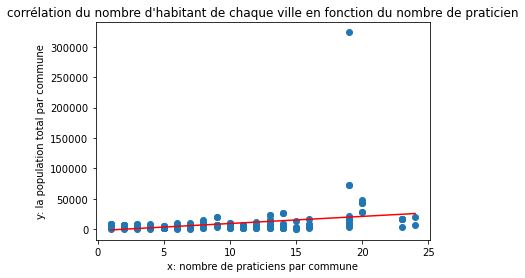

In [112]:
y = pd.Series(newDataFrame.PTOT) 
x = pd.Series(newDataFrame.nb_praticiens) 
plt.scatter(x, y) 
plt.title("corrélation du nombre d'habitant de chaque ville en fonction du nombre de praticien")
plt.xlabel('x: nombre de praticiens par commune') 
plt.ylabel('y: la population total par commune')
  
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1)) 
         (np.unique(x)), color='red') 

D'après le graph, il y a une légere augmentation des praticiens par rapport à la population.
on constate que pour les villes qui ont un nb_praticien compris entre 0 et 17, le nombre d'habitant est inférieur est à 50000.
Pour certaines ville dont le nombre de praticien est égal à 20, le nombre de d'habitant est supérieur à 300000.
le nombre de praticien est trés peu par rapport au nombre d'habitant pour certaines villes plus que d'autres.